# Exploration of local defocus shifts as a particle rejection criterion
This exploration was motivated by olibclarke's question at https://discuss.cryosparc.com/t/11632/5.

## Required
- Exposures with estimated `ctf/df1_A` values
- Particles with refined `ctf/df1_A` values
- A file with _valid_ CryoSPARC instance (connection) information like
  ```yaml
  license: 682437fb-d6ae-47b8-870b-b530c587da94
  host: localhost
  base_port: 39000
  email: username@email.server
  password: top7secret-phrase
  ```
  Actual values must correspond to the relevant CryoSPARC instance and CryoSPARC UI login information.
- a python environment with, aside from cryosparc-tools
  - pandas
  - matplotlib

In [2]:
%matplotlib inline
from cryosparc.tools import CryoSPARC
import cryosparc.dataset
import pandas
import matplotlib.pyplot as plt
import yaml

instance_info_file = '/tmp/release.yaml' # as described above

with open(instance_info_file, 'r') as yh:
    cs = CryoSPARC(**yaml.safe_load(yh))

## Input data

`J4` and `J17` are completed _Patch CTF_ and _Home Refine_ jobs from a run of the [benchmark workflow](https://guide.cryosparc.com/setup-configuration-and-management/software-system-guides/tutorial-verify-cryosparc-installation-with-the-extensive-workflow-sysadmin-guide) based on a subset of [EMPIAR-10025](https://doi.org/10.6019/EMPIAR-10025) movies.

In [13]:
project = cs.find_project('P44')
ctf_job = project.find_job('J4')
refine_job = project.find_job('J17')

For convienience, loaded datasets are converted to `pandas.DataFrame`s. The exposures dataset's index is [converted to a an `index` column](https://stackoverflow.com/a/20461206) for use in plotting, later

In [14]:
exposures_df = pandas.DataFrame(ctf_job.load_output('exposures').rows()
                               ).reset_index()
refine_particles_df = pandas.DataFrame(refine_job.load_output('particles').rows())

and joined on the exposure UIDs.

In [15]:
joined = refine_particles_df.merge(right=exposures_df, left_on='location/micrograph_uid',
                                   right_on='uid', suffixes=('.particle', '.exposure'))

## Hypothesis
Removal of particles with (absolute) shifts in their refined defocus values will result in a higher resolution reconstruction. Please refer to https://discuss.cryosparc.com/t/11632/5 for the olibclarke's actual intent.

In [16]:
joined['ctf/df1_A_diff'] = joined['ctf/df1_A.particle'] - joined['ctf/df1_A.exposure']

## Exploration

Shift distribution over entire dataset:

In [17]:
joined['ctf/df1_A_diff'].describe()

count    11736.000000
mean        67.377121
std        158.292664
min       -808.642578
25%        -18.759766
50%         69.953613
75%        166.506836
max        648.212891
Name: ctf/df1_A_diff, dtype: float64

and per ctf-estimated exposure:

<Axes: title={'center': 'ctf/df1_A_diff'}, xlabel='index'>

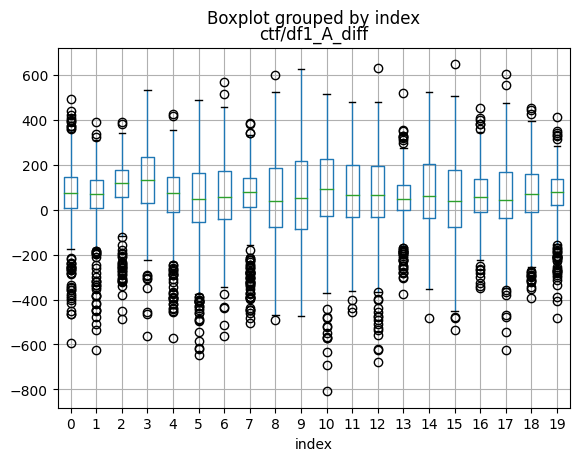

In [20]:
joined.boxplot(column='ctf/df1_A_diff', by='index')

Defocus shift distribution per micrograph. We next examine the effect of discarding particles whose defocus shifted outside the (-50&Aring;, +200&Aring;) interval and save retained particles.

In [44]:
selected_neg50_pos200 = (joined['ctf/df1_A_diff'] > -50) & (joined['ctf/df1_A_diff'] < 200)
print(f"Selected {sum(selected_neg50_pos200)} within defocus shift limits.")
selected_particle_dataset = refine_job.load_output('particles').mask(selected_neg50_pos200)
project.save_external_result(workspace_uid='W8', type='particle',
                             dataset=selected_particle_dataset)

Selected 7361 within defocus shift limits.


'J55'

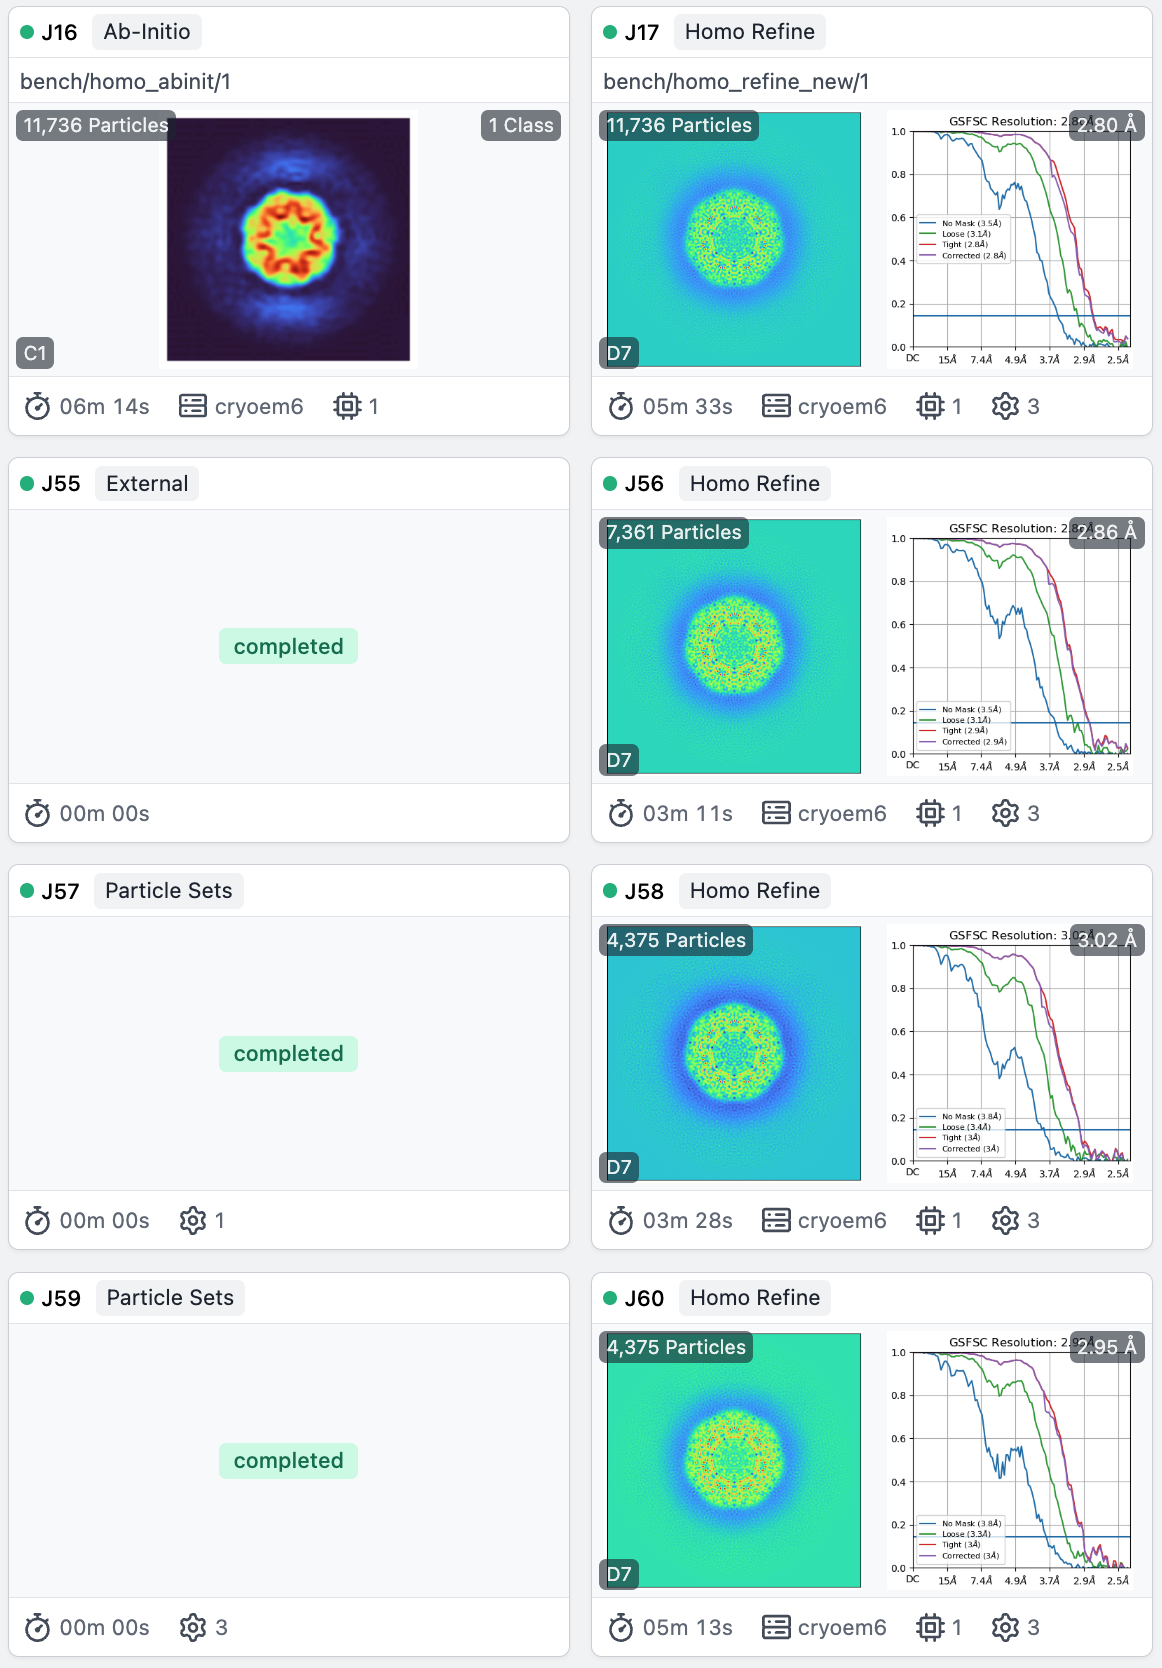

`J17:` Refinement from benchmark workflow: 11,736 particles, 2.80 &Aring; resolution.

`J56:` Refinement of particles within the allowed shift range: 7,361, 2.86 &Aring;.

`J58:` Refinement of particles outside the allowed shift range: 4,375, 3.02 &Aring;.

`J60:` Refinement of a random subset of particles within the allowed shift range: 4,375, 2.95 &Aring;.

The results are _nearly_ bad enough to reject the hypothesis. Things to try: 
- check if the code indeed rejected particles with larger shifts
- use shift w.r.t. mean refined defocus either within exposure or across all exposures
- use a scaled version of the shift as a rejection criterion
- reject particles with high defocus shift from a "dirtier" particle set, for example after omitting 2D classification-based "clean-up"
- ...